# **Hand On!**

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2022/11/10<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-10-29 16:04:24.052115: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 16:04:24.335794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 16:04:24.335814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 16:04:24.337733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 16:04:24.484390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 16:04:24.485764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  5019k      0  0:02:40  0:02:40 --:--:-- 5081k   0     0  5054k      0  0:02:39  0:01:15  0:01:24 4877k


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf	    kagglecatsanddogs_5340.zip	 UTKFace.ipynb
 Convolution_Neural_Network.ipynb   PetImages
 HandsOn-Animals.ipynb		   'readme[1].txt'


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [4]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [13]:
import os
import tensorflow as tf
from tensorflow.io import read_file, write_file
from tensorflow.image import decode_image

should_rewrite_image = True # set to true if you are getting Corrupt Data error
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join('PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        is_jfif = True
        should_remove = False
        
        with open(fpath, "rb") as fobj:
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            
        try:
            img = read_file(fpath)
            if not tf.io.is_jpeg(img):
                should_remove = True
                
            img = decode_image(img)

            if img.ndim != 3:
                should_remove = True

        except Exception as e:
            should_remove = True
        
        if (not is_jfif) or should_remove:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        elif should_rewrite_image:
            tmp = tf.io.encode_jpeg(img)
            write_file(fpath, tmp)

print("Deleted %d images" % num_skipped)

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


Deleted 2 images


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


## Generate a `Dataset`

In [14]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

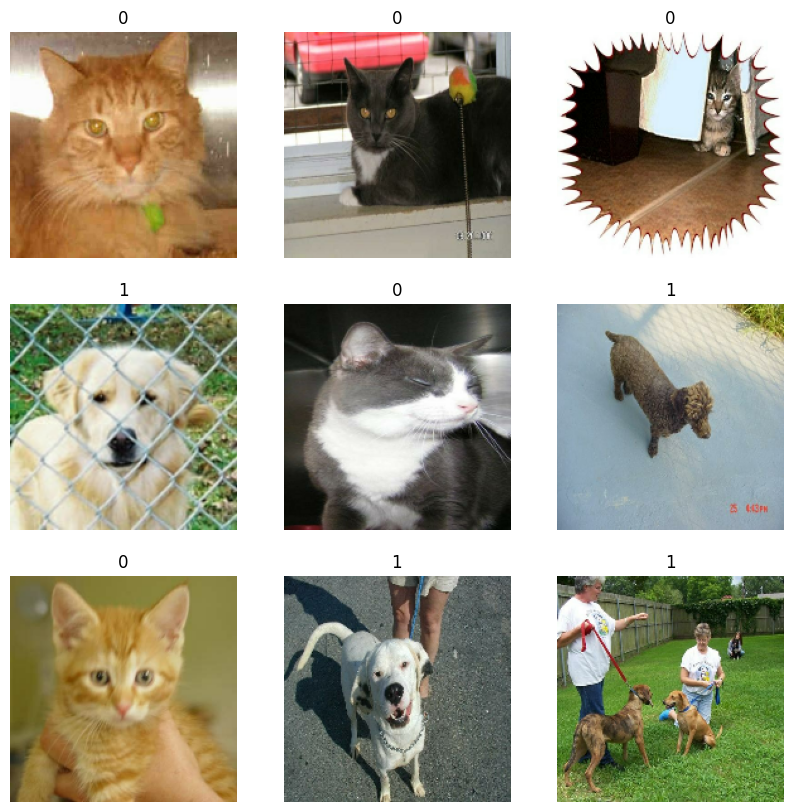

In [52]:
import matplotlib.pyplot as plt

class_labels = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    class_labels = labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [17]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

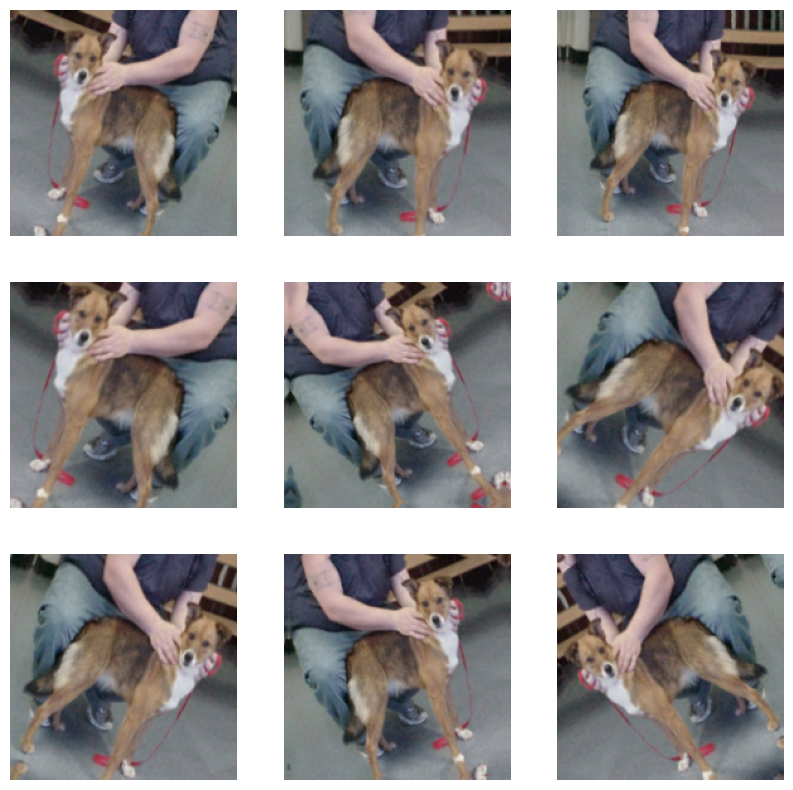

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

In [29]:
rescaling_layer = layers.Rescaling(1./255)

## Build a model

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [74]:
from keras import Sequential

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  # layers.Dense(2, activation='softmax')
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

## Train the model

Epoch 1/10
147/147 [==============================] - 104s 706ms/step - loss: 0.6753 - accuracy: 0.5682 - val_loss: 0.6086 - val_accuracy: 0.6651
Epoch 2/10
147/147 [==============================] - 102s 694ms/step - loss: 0.6199 - accuracy: 0.6577 - val_loss: 0.5939 - val_accuracy: 0.7108
Epoch 3/10
147/147 [==============================] - 103s 697ms/step - loss: 0.5890 - accuracy: 0.6843 - val_loss: 0.5477 - val_accuracy: 0.7202
Epoch 4/10
147/147 [==============================] - 105s 712ms/step - loss: 0.5782 - accuracy: 0.6961 - val_loss: 0.5712 - val_accuracy: 0.6909
Epoch 5/10
147/147 [==============================] - 103s 700ms/step - loss: 0.5551 - accuracy: 0.7122 - val_loss: 0.5122 - val_accuracy: 0.7608
Epoch 6/10
147/147 [==============================] - 106s 723ms/step - loss: 0.5392 - accuracy: 0.7290 - val_loss: 0.5278 - val_accuracy: 0.7290
Epoch 7/10
147/147 [==============================] - 105s 713ms/step - loss: 0.5237 - accuracy: 0.7399 - val_loss: 0.5632 -

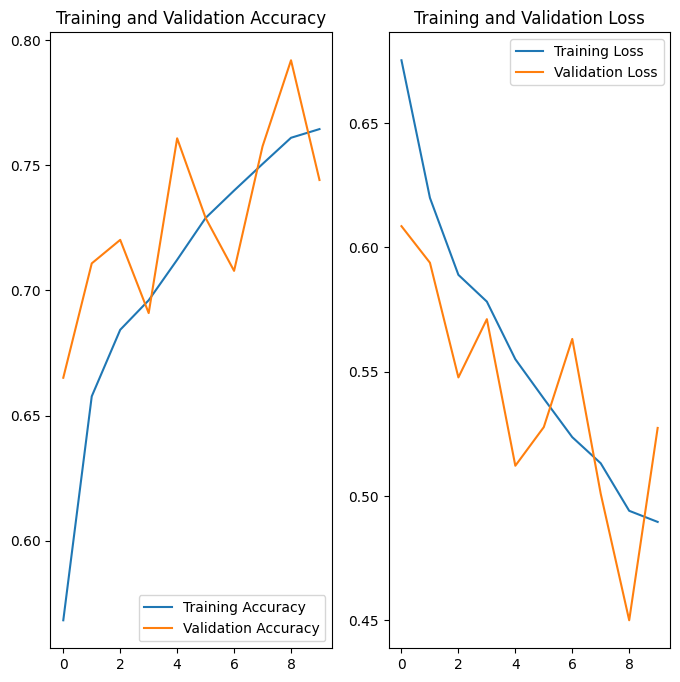

In [76]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [79]:
import numpy as np

dog_url = "https://img.freepik.com/free-photo/isolated-happy-smiling-dog-white-background-portrait-4_1562-693.jpg?w=1380&t=st=1698594013~exp=1698594613~hmac=e080e4273b652b86c788146e4169d8adb87781671f4e2c8605d9b4e99413d0fe"
cat_url = "https://i.guim.co.uk/img/media/26392d05302e02f7bf4eb143bb84c8097d09144b/446_167_3683_2210/master/3683.jpg?width=620&dpr=1&s=none"

for i, url in enumerate([dog_url, cat_url]):
    path = tf.keras.utils.get_file(f'test_{i}', origin=url)
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    print(f"Image {i} most likely belongs to Dog with a {100*np.max(predictions):.2f} percent confidence.")

1/1 [==============================] - 0s 11ms/step
Image 0 most likely belongs to Dog with a 90.72 percent confidence.
1/1 [==============================] - 0s 11ms/step
Image 1 most likely belongs to Dog with a 1.08 percent confidence.
